# V-JEPA

![image](https://scontent-lga3-1.xx.fbcdn.net/v/t39.8562-6/427979095_923374739138637_7724069779118251294_n.png?_nc_cat=108&ccb=1-7&_nc_sid=f537c7&_nc_ohc=JE33cmrnZf8Ab6vPHgs&_nc_ht=scontent-lga3-1.xx&oh=00_AfCY2XCfGZoRVdG5JxhZihJyBdaZk47HmnGqtF0wnis2SA&oe=6620A34A)

From [here](https://ai.meta.com/blog/v-jepa-yann-lecun-ai-model-video-joint-embedding-predictive-architecture/).

## Video JEPA in focus

V-JEPA is a non-generative model that learns by predicting missing or masked parts of a video in an abstract representation space. This is similar to how our Image Joint Embedding Predictive Architecture (I-JEPA) compares abstract representations of images (rather than comparing the pixels themselves). Unlike generative approaches that try to fill in every missing pixel, V-JEPA has the flexibility to discard unpredictable information, which leads to improved training and sample efficiency by a factor between 1.5x and 6x.

Because it takes a self-supervised learning approach, V-JEPA is pre-trained entirely with unlabeled data. Labels are only used to adapt the model to a particular task after pre-training. This type of architecture proves more efficient than previous models, both in terms of the number of labeled examples needed and the total amount of effort put into learning even the unlabeled data. With V-JEPA, we’ve seen efficiency boosts on both of these fronts.

With V-JEPA, we mask out a large portion of a video so the model is only shown a little bit of the context. We then ask the predictor to fill in the blanks of what’s missing—not in terms of the actual pixels, but rather as a more abstract description in this representation space.


## Acquire Data

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
%%time

# Load the MNIST dataset
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step
CPU times: user 523 ms, sys: 116 ms, total: 639 ms
Wall time: 1.14 s


In [3]:
# Normalize the data to help with training
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension

In [4]:
def create_pairs(x, digit_indices):
    '''Creates a balanced dataset of pairs'''
    pairs = []
    labels = []

    n = min([len(digit_indices[d]) for d in range(10)]) - 1

    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i+1]
            pairs += [[x[z1], x[z2]]]
            inc = np.random.randint(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

In [5]:
# Create a digit_indices list to store the indices for each class
digit_indices = [np.where(y_train == i)[0] for i in range(10)]

# Create pairs
pairs, labels = create_pairs(x_train, digit_indices)

# Split pairs and labels into x1, x2, and y
x1 = pairs[:, 0]
x2 = pairs[:, 1]
y = labels

# Check shapes
print("x1 shape:", x1.shape)
print("x2 shape:", x2.shape)
print("y shape:", y.shape)

x1 shape: (108400, 28, 28, 1)
x2 shape: (108400, 28, 28, 1)
y shape: (108400,)


The provided code defines and implements a Siamese neural network using TensorFlow and Keras. This network uses two encoders to process two different inputs and determine whether they are similar or not, typically used for tasks like face verification or comparing items. The key aspects of this implementation involve the network architecture, weight management, and the custom backpropagation mechanism. Here's a high-level overview of the main components and processes:



### Network Architecture

1. **Encoders Definition**: Two identical encoders are defined using the `create_encoder` function. Each encoder consists of a series of layers (`Flatten`, `Dense`) designed to convert the input images into a compressed feature representation.
2. **Trainable and Non-Trainable Encoders**: The `encoder_main` is intended to learn from the data during training, while `encoder_ma` (moving average encoder) has its training disabled (`trainable=False`). This makes `encoder_ma` unaffected directly by backpropagation.



### Training Mechanism and Backpropagation

1. **Backpropagation on `encoder_main`**: During training, only `encoder_main` and the final output layer are subject to weight updates through backpropagation. This is achieved by explicitly calculating gradients for only the trainable variables of `encoder_main` and the output layer.
2. **Non-Backpropagation on `encoder_ma`**: Since `encoder_ma` is set to non-trainable, TensorFlow does not compute or apply gradients to its weights. Thus, it does not learn directly from the training data.
3. **Weight Update via Moving Average**: Instead of learning through backpropagation, `encoder_ma`'s weights are updated based on the weights of `encoder_main`. After each training step, each weight in `encoder_ma` is adjusted to be a weighted average of its current value and the corresponding value from `encoder_main`. This update uses a factor `alpha` to balance between the old values and the new ones from `encoder_main`.



### Custom Training Step

The `train_step` method you've provided is a customized training loop for a TensorFlow Keras model, specifically tailored for a Siamese neural network setup with a unique twist: it uses outputs from one of its own encoders as pseudo-ground truth to guide its training. This method is part of a self-supervised learning approach where labels are not used or are unavailable. Here's a breakdown of what each part of the method does:

### Unpacking Data

- **Unpacking the Input**: The input data `data` is expected to be a tuple, typically of the form `(inputs, labels)`. In this setup, `x` represents the inputs which are two distinct sets of images (from `x1` and `x2`), and `_` is a placeholder ignoring the actual labels since they are not used.

### Forward Pass

- **Gradient Tracking**: `tf.GradientTape()` is used to track operations for automatic differentiation. This is essential for neural networks where gradients need to be computed for backpropagation.
- **Pseudo-Ground Truth Generation**: The method uses `encoder_ma` (moving average encoder) to process the second set of inputs `x[1]`. The output of this encoder is treated as the pseudo-ground truth, effectively what `encoder_main` should aim to produce when it processes the first set of inputs `x[0]`.
- **Prediction and Loss Calculation**: The `encoder_main` processes the first set of inputs `x[0]`, generating predictions `y_pred`. The loss is computed by comparing these predictions to the pseudo-ground truth `pseudo_y` using `self.compiled_loss`, which is a method to calculate loss as configured during model compilation.

### Backward Pass and Weight Updates

- **Gradient Computation**: Gradients of the loss with respect to the trainable variables (weights and biases of `encoder_main` and the output layer) are calculated.
- **Applying Gradients**: The computed gradients are applied to the trainable variables using an optimizer (such as Adam, SGD, etc.), which adjusts the weights to minimize the loss.
- **Moving Average Update**: In addition to the typical training updates, the weights of `encoder_ma` are updated as a moving average of the weights from `encoder_main`. This helps `encoder_ma` to slowly adapt and stabilize over time, influenced by the learning progress of `encoder_main`.

### Metric Updates and Return

- **Metric Updates**: Any metrics that have been compiled with the model (like accuracy or loss) are updated using the pseudo-ground truth and the predictions. This helps in monitoring the model's performance during training.
- **Return Statement**: The method returns a dictionary containing the results of the metric evaluations for this training step. This output is useful for tracking training progress over each batch.

### Overall Functionality
This method is quite innovative in that it uses part of the model itself to generate targets for training another part of the model. This can be particularly useful in scenarios where true labels are not available, allowing the model to still learn useful representations by trying to ensure consistency between the outputs of two differently behaving parts of the same network. This approach aligns with self-supervised learning strategies, which are increasingly popular for leveraging unlabeled data.

### Usage in a Siamese Model

- The `call` function in `SiameseModel` takes two inputs, passes each through its respective encoder, and then processes the differences in their output features to make a final prediction. The absolute difference of the feature vectors (from `encoder_main` and `encoder_ma`) is used to compute a similarity score, which is finally passed through a sigmoid activation function to classify the inputs as similar or not.

### Summary
This architecture is particularly useful in scenarios where one wants to stabilize the learning process by having one encoder (`encoder_ma`) that does not directly learn from backpropagation but instead slowly tracks another more rapidly learning encoder (`encoder_main`). This approach can help in making the model's learning more robust and less prone to rapid shifts due to noisy data or outliers.

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model

# Define the base encoder architecture
def create_encoder():
    input_layer = Input(shape=(28, 28, 1))
    x = Flatten()(input_layer)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Dense(1, activation='relu')(x)
    return Model(inputs=input_layer, outputs=x)

# Create the main and the moving average encoder
encoder_main = create_encoder()
encoder_ma = create_encoder()

# Make the moving average encoder non-trainable
encoder_ma.trainable = False

In [28]:
class VJEPA(tf.keras.Model):
    def __init__(self, encoder_main, encoder_ma, alpha=0.1):
        super(VJEPA, self).__init__()
        self.encoder_main = encoder_main
        self.encoder_ma = encoder_ma
        self.alpha = alpha  # Moving average factor
        self.output_layer = Dense(1, activation='sigmoid')

    def call(self, inputs):
        input1, input2 = inputs

        # Get features from both encoders
        features1 = self.encoder_main(input1)
        features2 = self.encoder_ma(input2)

        # Combine features (e.g., by subtracting)
        combined_features = tf.abs(features1 - features2)

        # Output prediction
        return self.output_layer(combined_features)

    def train_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass & compute gradients on trainable weights
        with tf.GradientTape() as tape:
            y_pred = self((x[0], x[1]), training=True)
            loss = self.compiled_loss(y, y_pred)

        # Calculate gradients
        trainable_vars = self.encoder_main.trainable_variables + self.output_layer.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update the weights of the main encoder and output layer
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the moving average encoder weights
        for a, b in zip(self.encoder_ma.variables, self.encoder_main.variables):
            a.assign(self.alpha * a + (1 - self.alpha) * b)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_pred)

        return {m.name: m.result() for m in self.metrics}

    # def train_step(self, data):
    #     # Unpack the data
    #     x, _ = data  # Ignore actual labels, but correctly unpack the tuple

    #     # Forward pass & compute gradients on trainable weights
    #     with tf.GradientTape() as tape:
    #         # We use encoder_ma's output as pseudo-ground truth for the second input
    #         pseudo_y = self.encoder_ma(x[1])
    #         y_pred = self.encoder_main(x[0])
    #         loss = self.compiled_loss(pseudo_y, y_pred)

    #     # Calculate gradients
    #     trainable_vars = self.encoder_main.trainable_variables + self.output_layer.trainable_variables
    #     gradients = tape.gradient(loss, trainable_vars)

    #     # Update the weights of the main encoder and output layer
    #     self.optimizer.apply_gradients(zip(gradients, trainable_vars))

    #     # Update the moving average encoder weights
    #     for a, b in zip(self.encoder_ma.variables, self.encoder_main.variables):
    #         a.assign(self.alpha * a + (1 - self.alpha) * b)

    #     # Update the metrics
    #     self.compiled_metrics.update_state(pseudo_y, y_pred)

    #     return {m.name: m.result() for m in self.metrics}


## Define Model

In [36]:
# Instantiate and compile the model
model = VJEPA(encoder_main, encoder_ma)

### Compiler

In [37]:
import tensorflow as tf

def custom_lr_scheduler(epoch, lr):
    """ Custom learning rate scheduler.

    Args:
    epoch (int): The current training epoch.
    lr (float): The current learning rate.

    Returns:
    float: The adjusted learning rate.
    """
    # Reduce the learning rate after 10 epochs
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Create the Adam optimizer with an initial learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile the model with the new optimizer and a custom learning rate scheduler
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## Training

In [41]:
%%time

# Create dummy labels (they won't actually be used)
dummy_y = np.zeros((len(x1), 1))  # Create an array of zeros

# Fit the model
model.fit(
    [x1, x2], # sets of inputs
    y, # dummy y (all zeros), but the model doesn't use this
    batch_size=32,
    validation_split=0.2,
    epochs=100)

Epoch 1/100
2710/2710 [==============================] - 17s 6ms/step - loss: 0.1501 - accuracy: 0.9637 - val_loss: 2.7171 - val_accuracy: 0.6186
Epoch 2/100
2710/2710 [==============================] - 17s 6ms/step - loss: 0.1503 - accuracy: 0.9649 - val_loss: 2.9006 - val_accuracy: 0.6145
Epoch 3/100
2710/2710 [==============================] - 18s 7ms/step - loss: 0.1506 - accuracy: 0.9663 - val_loss: 3.5012 - val_accuracy: 0.6111
Epoch 4/100
2710/2710 [==============================] - 18s 6ms/step - loss: 0.1422 - accuracy: 0.9682 - val_loss: 3.3777 - val_accuracy: 0.6128
Epoch 5/100
2710/2710 [==============================] - 18s 7ms/step - loss: 0.1531 - accuracy: 0.9630 - val_loss: 2.6765 - val_accuracy: 0.6255
Epoch 6/100
2710/2710 [==============================] - 18s 7ms/step - loss: 0.1455 - accuracy: 0.9650 - val_loss: 3.2863 - val_accuracy: 0.6189
Epoch 7/100
2710/2710 [==============================] - 17s 6ms/step - loss: 0.1463 - accuracy: 0.9659 - val_loss: 3.5673 -

In [44]:
%%time

yhat = model.predict([x1, x2])
yhat.shape

3388/3388 [==============================] - 9s 3ms/step
CPU times: user 11.9 s, sys: 2.13 s, total: 14 s
Wall time: 12.9 s


(108400, 1)

### Accuracy

We discretize the prediction `yhat` and see how much of it is the same as the ground truth `y`.

In [61]:
yhat = (yhat > yhat.mean())
((yhat).reshape(-1).astype(int) == y).mean()

0.9054981549815498

## Visualize Similarity

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image_pairs(x1, x2, y, yhat, num_pairs=5):
    """
    Plots a grid of image pairs from x1 and x2, showing whether they are the same or not,
    and also displays the predicted result which is color-coded to indicate correctness.

    Args:
    x1 (np.array): Array of images.
    x2 (np.array): Array of images.
    y (np.array): Array indicating whether images in x1 and x2 are from the same class (1) or not (0).
    yhat (np.array): Array of predicted labels, where 1 indicates 'Same' and 0 indicates 'Different'.
    num_pairs (int): Number of image pairs to plot, sampled randomly.
    """
    plt.figure(figsize=(10, 2 * num_pairs))

    # Generate random indices
    indices = np.random.choice(len(x1), num_pairs, replace=False)

    for idx, i in enumerate(indices):
        # Plot image from x1
        plt.subplot(num_pairs, 2, 2*idx + 1)
        plt.imshow(x1[i].reshape(28, 28), cmap='gray')
        plt.title('Image 1')
        plt.axis('off')

        # Plot image from x2
        plt.subplot(num_pairs, 2, 2*idx + 2)
        plt.imshow(x2[i].reshape(28, 28), cmap='gray')

        # Determine the labels and color for the title based on actual and predicted values
        actual_label = "Same" if y[i] == 1 else "Different"
        predicted_label = "Same" if yhat.reshape(-1)[i] == 1 else "Different"
        title_color = 'green' if actual_label == predicted_label else 'red'

        plt.title(f'Real: {actual_label}, Predicted: {predicted_label}', color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

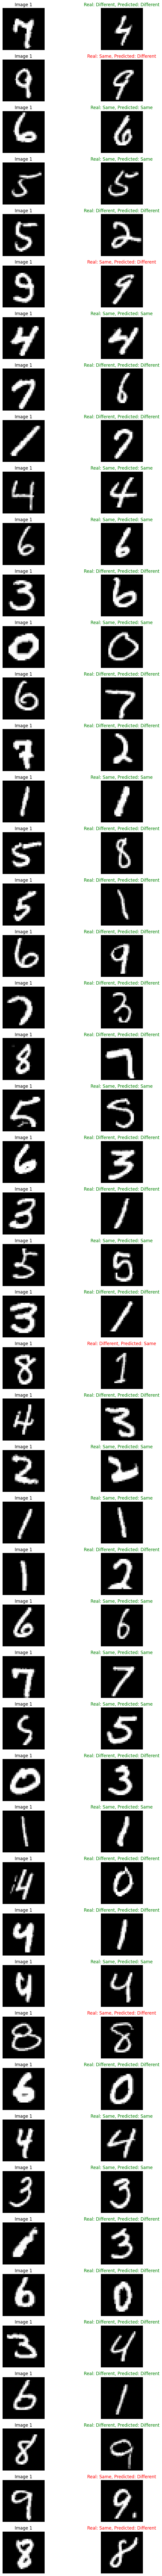

In [65]:
# Example usage of the function
# Ensure x1, x2, y, and yhat are defined and loaded appropriately before calling this function.
plot_image_pairs(x1, x2, y, yhat, num_pairs=50)